In [342]:
import pandas as pd, numpy as np, matplotlib as plt, seaborn, sqlite3 as db, encodings, nltk
from sklearn.datasets import load_files
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB, BernoulliNB

%matplotlib inline
seaborn.set_style('darkgrid')

# import sys
# reload(sys)
# sys.setdefaultencoding("utf-8")

In [343]:
db_file  =  '/Users/davidyerrington/virtualenvs/data/political_bias/corpus.db'
conn     =  db.connect(db_file)

sql_cons =  "SELECT * FROM content WHERE political_view = 'conservative'"
sql_lib  =  "SELECT * FROM content WHERE political_view = 'progressive'"

cons_df  =  pd.read_sql(sql_cons, con=conn)
lib_df   =  pd.read_sql(sql_lib, con=conn)

conn.close()


In [344]:
def get_pos(text):
    
    chars  =  text.split(" ")
    
    words  =  [nltk.word_tokenize(word) for word in chars]
    pos    =  [nltk.pos_tag(word) for word in words]
    
    return pos
    
def substring_index(substring, target_list):
    
    for index, item in enumerate(target_list):
        
        if substring in item:
            return index
    
    return False

def filter_mother_legacy(text):
    
    lines  =  text.split('\n')
    offset =  lines.index('FOLLOW MOTHER JONES')
        
    test_offset = sub_index('Alex Park', text)
    pattern_found = False
    
    for index, line in enumerate(lines):
        
        pos = get_pos(line)
        # print line, pos
        try:
            #word, token = pos[0][0]
            
            first_two_nnp =  pos[0][0][1] == 'NNP' and pos[1][0][1] == 'NNP'
            third_vbz     =  pos[2][0][1] == 'VBZ'
            fourth_dt     =  pos[3][0][1] == 'DT'
            
            if first_two_nnp and third_vbz and fourth_dt:
                print index, pos[0][0][0], pos[1][0][0], pos[2][0][0], pos[3][0][0], pos[4][0][0]
                print index, pos[0][0][1], pos[1][0][1], pos[2][0][1], pos[3][0][1], pos[4][0][1]
                pattern_found = True
        except:
            
            _ = ''
            
    if not pattern_found:
        print "Couldn't find jack in: ", text
    print "--------------------------------------------------"
#     print get_pos(lines[15])[0][0][1]
#     print lines[test_offset]
    
    return lines[0:offset]

total_authors_pruned = 0
total_cruft_pruned = 0

# girl edition because "girl" suggested this method.. it is a good one!
def filter_mother_girl_edition(text):
    
    lines = text.split("\n")
    
    if len(lines[0]) < 40:
        
        try:  
            
            found_index =  False
            _, name     =  lines[0].split(u"—By ")
            if 'and' in name:
                name.split(' and ')[0]
            
            for offset, line in enumerate(lines):
                
                if name in line and 'Mother Jones' in line:
                    found_index = offset
                    print 'Found %s on line %d' % (name, offset)
                    return "\n".join(lines[0: offset])
            
            if not found_index:
                offset =  lines.index('FOLLOW MOTHER JONES')
                return "".join(lines[0:offset])
                
        
            print "---------------------------------------------"
            
            # print offset
            
        except:
            _ = ''
    
    else:
        return text
#         print "no beards here sucka!", text
 
lib_df['content_text'] = lib_df['content_text'].map(filter_mother_girl_edition)
lib_df = lib_df.dropna(axis=0)

print lib_df.count()

# print lib_df  
# print 'Pruned by author: %d, Pruned by "MOTHER JONES": %d' % (total_authors_pruned, total_cruft_pruned)

content_df  = cons_df.head(1350).append(lib_df)

Found Alex Park on line 15
Found Jaeah Lee on line 10
Found Jenna McLaughlin on line 9
Found Gabrielle Canon on line 8
Found Andy Kroll on line 8
Found Tim Murphy on line 21
Found Patrick Caldwell on line 4
Found Inae Oh on line 6
Found Patrick Caldwell on line 8
Found David Corn on line 10
Found Laura Gottesdiener on line 74
Found Inae Oh on line 11
Found Patrick Caldwell on line 7
Found Hannah Levintova on line 19
Found Ben Dreyfuss on line 78
Found Jenna McLaughlin on line 20
Found Tim Murphy on line 5
Found Samantha Michaels on line 6
Found Erika Eichelberger on line 16
Found Erika Eichelberger on line 10
Found Tim Murphy on line 41
Found Pema Levy on line 13
Found Shane Bauer on line 9
Found Becca Andrews on line 6
Found Tim Murphy on line 14
Found AJ Vicens on line 10
Found Ben Dreyfuss on line 4
Found Tim Murphy on line 9
Found Tim Murphy on line 29
Found Inae Oh on line 9
Found Tim Murphy on line 15
Found Pema Levy on line 13
Found Samantha Michaels on line 7
Found Jaeah Lee on

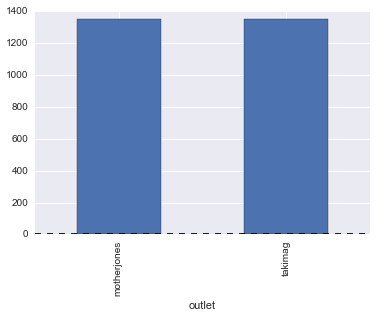

In [345]:
content_df.groupby('outlet').count()['url'].plot(kind='bar')
# content_df.groupby('outlet').count()


In [346]:
content_df[content_df['content_text'] == ''].count()
# content_df['content_text'].values

index             4
url               4
outlet            4
political_view    4
content_text      4
dtype: int64

## Setup - Vectorize our corpus texts
Before our classifier can recognize our data, it needs to be vectorized.  (TBD:  find link for tfidf from scratch / intuition)

In [347]:
# CountVectorizer?

# types = []
# records = content_df.to_dict('records')

# for row in records:
    
#     if type(row['content_text']) != unicode:
#         print row

count_vect      =   CountVectorizer(input="conent", lowercase=False, strip_accents='ascii')
X_train_counts  =   count_vect.fit_transform(content_df['content_text'])

# print "Shape (documents x features):", X_train_counts.shape

# X_train_tfidf = vectorizer.fit_transform(content_df['content_text'].values)
# Y_train = content_df['political_view'].values

### Autobots, transform!  
At this point, we need to convert the term frequency (tf), and term frequency inverse document frequency (tf-idf).

In [348]:
tf_transformer  =   TfidfTransformer(use_idf=False).fit(X_train_counts)
X_train_tf      =   tf_transformer.transform(X_train_counts)

print "Shape (documents x features):", X_train_tf.shape

Shape (documents x features): (2702, 59927)


### Train a classifier

In [349]:
classifier = MultinomialNB() # BernoulliNB()
classifier.fit(X_train_tf, content_df['political_view'])
# print("Training score: {0:.1f}%".format(
#     classifier.score(X_train, Y_train) * 100))

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [350]:
docs_new = ["""On Sunday, President Barack Obama announced that the official name for the highest peak in North America, Alaska's Mount McKinley, would formally be changed to its Athabascan name: Denali. This makes a lot of sense. The mountain was known as Denali long before a gold prospector dubbed it McKinley after reading a newspaper headline in 1896, and it has officially been known as "Denali" in Alaska for about a century, according to the state's board for geographic names. The state and its Republican legislature have been asking Washington to call the mountain Denali for decades. And for decades, the major obstacle to getting this done has been Ohio, McKinley's home state. We need not spend much time discussing Ohio in this space, but suffice it to say that Ohioans are a very proud, if sometimes misinformed, people, and the birthplace of mediocre presidents won't just take the marginalization of those mediocre presidents lying down. It will fight! To wit, the state's congressional delegation has decided to show off that old Ohio fighting spirit by condemning the decision in sternly worded press releases and tweets. Here's GOP Sen. Rob Portman""", 
            """Inspired by this remarkable victory, the GOP began a “war of the sexes” that would garner as much sex as possible for men. The biggest obstacle they had was the fact that women can create life. This makes them less likely to spread their legs for every Tom, Dick, and Harry who comes along. The solution to this was simple: trivialize it. Make women think it’s an irrelevant detail that’s downright disgusting. This took some convincing, but today it’s not unusual to see a young woman turn her nose up at the act like it’s the same as shitting out a tumor.""",
            """Why does liberal society function as well as it does? Ordinary people and theoreticians complain about it, its proponents have trouble defending it coherently, and its imminent demise has been announced since long before any of us were born. Nonetheless, it is more widespread and firmly rooted than ever and in its development it goes from victory to victory. Most people aren’t willing to say so explicitly, but it is generally viewed as the final form of human society, a permanent achievement that has definitively triumphed and can never be superseded.
What is going on? Is liberalism strong in spite of seeming weakness or weak in spite of seeming strength? It is difficult to view such a dominant outlook from a perspective that is independent enough to allow assessment of its true strength. Several lines of thought seem relevant, however:

Liberalism is associated with other things that counteract its effects and make possible non-traditional ways of doing things, for example modern natural science and technology, which multiply both wealth and power over nature and society, and thus make up for weaker social connections.
It is farthest advanced in the societies that can afford it, those with steady and lawful habits, and it finds methods—public education, bureaucratic careerism, development and centralization of the media of communication, weakening of independent forms of social organization—to keep the habits of the people in line with its requirements.
It is a tendency rather than a system, and on the whole has moved slowly and cautiously. It has generally avoided pushing its principles to the limit and destroying completely the things it opposes but depends upon, such as traditional family and similar relationships. Also, it develops partial substitutes for what it destroys. Even though liberalism can’t base family relations on anything but contract or arbitrary sentimental attachment, and therefore has no way to understand sexual differences, it took hundreds of years for it to draw the obvious conclusions with regard to sex roles and homosexuality, and then only when it seemed possible to fill the gap created by family disorder with bureaucratized social services and daycare, including a greatly expanded system of public “education,” and to some extent to substitute immigration for childbearing.
As time has passed and antiliberal institutions and views fallen into disarray liberal restraint has weakened greatly. The ’60s were decisive in that process. It seems therefore that post-60s liberationist liberalism can’t appeal to the long historical success of preceeding forms of liberalism as reason to think it will be similarly successful. That is the element of truth in neoconservatism.
So what now? The liberal democracies continue to prosper economically and grow in power relative to the rest of the world. No real alternative to liberalism has appeared. Nonetheless failures are appearing that seem likely to be decisive in the coming decades because in principle they make it impossible for liberal society to continue and it’s quite unclear what resources there are in liberal society that will make it possible to deal with them. The most notable of these is the inability of liberal society to reproduce itself, culturally—the corruption of education, intellectual life and even science is a serious matter—or even physically. Another is the increasing inability of liberal elites to think or engage in self-limitation or self-criticism. Another is growing corruption and self-seeking in public life. Again, the problem is not so much that these things are problems as that it appears that as liberalism develops it becomes less and less able to deal with them.

Still, a system that is dead in principle can stumble on a surprisingly long time if nothing is available to replace it. So the key question for the next few decades is likely to be whether ways of life at odds with liberalism—radical Islam or traditionalist Christianity, for example—will be attractive enough to gain and hold enough adherents to give liberalism genuine competition.""",
           """According to a new report from the University of Illinois at Urbana-Champaign, racial bias can affect the likelihood of people pulling the trigger of a gun—even if shooters don't realize they were biased to begin with. Researchers found that, in studies conducted over the past decade, participants were more likely to shoot targets depicting black people than those depicting white people.

A team led by researcher Yara Mekawi looked at 42 studies that used first-person-shooter tasks to identify shooter bias. In the lab, images of black or white people were shown to participants, who then had less than a second to decide whether they would shoot the target. In some images the people were armed, and in others they were holding another object, like a cellphone.

The meta-analysis showed that the participants were quicker to shoot when an armed person was black, slower to choose not to shoot when an unarmed person was black, and more trigger-happy toward black targets in general.

There was little difference between false-alarm shootings between black and white targets overall; however, in states where gun laws are less strict, shooter bias against black targets increased—unarmed black targets were more likely to be shot. The bias only got worse in areas that were more racially diverse.

"What this highlights," Mekawi told NPR, "is that even though a person might say, 'I'm not racist' or 'I'm not prejudiced,' it doesn't necessarily mean that race doesn't influence their split-second decisions."""]

categories = ['progressive', 'conservative']

X_new_counts = count_vect.transform(docs_new)
X_new_tfidf = tf_transformer.transform(X_new_counts)

predicted_proba = classifier.predict_proba(X_new_tfidf)
for row in predicted_proba:
    print "Document predicted: %.02f Conservative / %.02f Progressive" % tuple(row) 

predicted = classifier.predict(X_new_tfidf)

for doc, category in zip(docs_new, predicted):
    print('%r => %s' % (len(doc), category))
    
# print predicted.
    
# classifier.predict(X_lame_test)

# X_lame_test), np.shape(X_train)
# X_lame_test
# X_train
# X_lame_test

# classifier.predict(X_lame_test)

Document predicted: 0.34 Conservative / 0.66 Progressive
Document predicted: 0.73 Conservative / 0.27 Progressive
Document predicted: 0.71 Conservative / 0.29 Progressive
Document predicted: 0.40 Conservative / 0.60 Progressive
1154 => progressive
569 => conservative
4132 => conservative
1517 => progressive


### Compare probability scores pre / post motherjones cleanup

#### Before
* Document predicted: 0.17 Conservative / 0.83 Progressive
* Document predicted: 0.61 Conservative / 0.39 Progressive
* Document predicted: 0.51 Conservative / 0.49 Progressive
* Document predicted: 0.27 Conservative / 0.73 Progressive
- 1154 => progressive
- 569 => conservative
- 4132 => conservative
- 1517 => progressive

mean **Progressive** probabilities: **0.609716380072**

#### After

* Document predicted: 0.15 Conservative / 0.85 Progressive
* Document predicted: 0.49 Conservative / 0.51 Progressive
* Document predicted: 0.44 Conservative / 0.56 Progressive
* Document predicted: 0.19 Conservative / 0.81 Progressive
- 1154 => progressive
- 569 => progressive
- 4132 => progressive
- 1517 => progressive

mean **Progressive** probabilities: **0.683050075802**

This shows that our preprocessing of the motherjones slice of the text, improved accuracy of progressive sources, however, futher validation is necessary with a good split (70/30) using scraped data.

In [340]:
proba_df = pd.DataFrame(predicted_proba, columns=['conservative', 'progressive'])
print proba_df
print "mean progressive probabilities:", proba_df['progressive'].mean()

   conservative  progressive
0      0.149946     0.850054
1      0.485271     0.514729
2      0.441340     0.558660
3      0.191242     0.808758
mean progressive probabilities: 0.683050075802


In [156]:
def plot_roc_curve(target_test, target_predicted_proba, categories):
    from sklearn.metrics import roc_curve
    from sklearn.metrics import auc
    
    for pos_label, category in enumerate(categories):
        print pos_label, category
        fpr, tpr, thresholds = roc_curve(target_test, target_predicted_proba[:, pos_label], pos_label)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label='{} ROC curve (area = {:.3f})'.format(category, roc_auc))
    
    plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate or (1 - Specifity)')
    plt.ylabel('True Positive Rate or (Sensitivity)')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")

In [158]:
# categories = tuple(set(content_df['political_view'].values))
plot_roc_curve(docs_new, content_df['political_view'], categories)

0 progressive


ValueError: Can only tuple-index with a MultiIndex